## Ring-hydroxylating Dioxygenases

In [1]:
from protlearn import *

[nltk_data] Downloading package punkt to /Users/lucas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lucas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Create data frame from raw data and clean it
msa_file = 'alignment.fasta'
msa = MSA()
msa.parse_msa_file(msa_file)
print(msa.raw_data.info)

<bound method DataFrame.info of                          0    1    2    3    4    5    6    7    8    9      
A0A1V1ZE67_9FLAO/178-361    -    -    -    -    -    -    -    -    -    -  \
A0A0J1DCU0_9BURK/170-416    -    -    -    -    -    -    -    -    -    -   
J2WKD9_9SPHN/182-387        -    -    -    -    -    -    -    -    -    -   
A0A1Q3AVG0_CEPFO/233-414    -    -    -    -    -    -    -    -    -    -   
A0A5N0VGT3_9PSEU/179-385    -    -    -    -    -    -    -    -    -    -   
...                       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
A0A109D4U5_9BURK/167-435    -    -    -    -    -    -    -    -    -    -   
Q63MU4_BURPS/184-418        -    -    -    -    -    -    -    -    -    -   
A0A1M7PUQ5_9ACTN/175-372    -    -    -    -    -    -    -    -    -    -   
A0A4Q4THZ6_9PEZI/248-366    -    -    -    -    -    -    -    -    -    -   
A0A318HGY1_9BURK/191-426    -    -    -    -    -    -    -    -    -    -   

                          ... 1

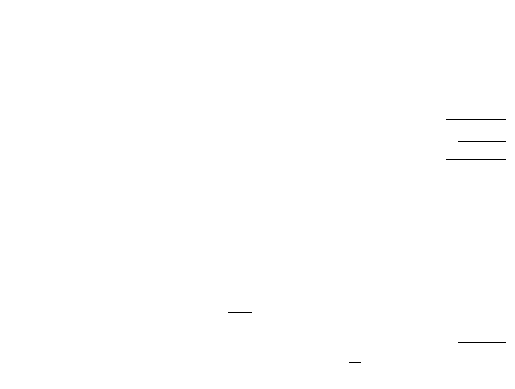

<bound method DataFrame.info of      182 185 186 187 200 204 205 206 216 217  ... 838 841 845 848 851 853 982   
0      A   L   Y   C   E   G   F   H   V   H  ...   T   Y   V   Y   D   E   E  \
1      K   L   Y   M   D   P   Y   H   L   H  ...   Y   F   G   Y   E   D   D   
2      K   L   T   Y   E   N   Y   H   I   H  ...   L   Y   W   K   G   E   E   
3      K   V   F   C   D   G   Y   H   A   H  ...   Y   F   L   E   G   S   E   
4      K   V   V   N   E   C   Y   H   N   H  ...   W   F   V   A   D   A   Q   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
7562   K   L   M   Q   D   P   Y   H   L   H  ...   H   F   G   F   E   E   D   
7564   K   M   Y   L   D   T   V   H   T   H  ...   S   F   R   A   A   G   D   
7565   K   L   T   M   E   C   Y   H   N   H  ...   W   L   V   H   R   D   Q   
7566   K   L   V   V   D   F   Y   H   V   H  ...   V   F   V   D   N   S   Q   
7567   K   L   T   M   E   C   Y   H   N   H  ...   W   C   V   H   R   D   Q

In [3]:
msa.cleanse_data(plot=True)
print(msa.data.info)

In [4]:
msa.analyse(plot=True)
msa.reduce()
print(msa.coordinates.shape)

(6469, 2)


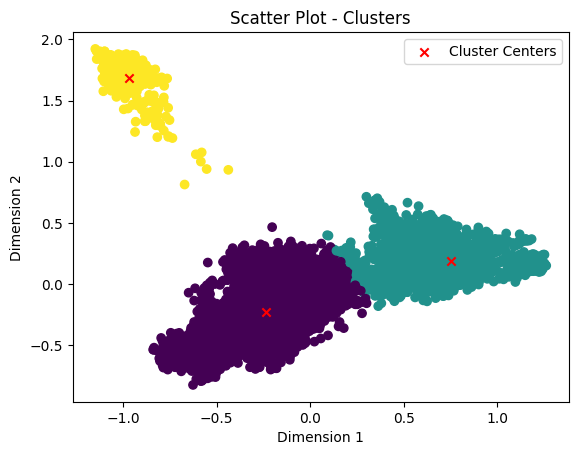

[0 1 0 ... 0 0 0]


In [5]:
msa.get_labels(plot=True)
print(msa.labels)

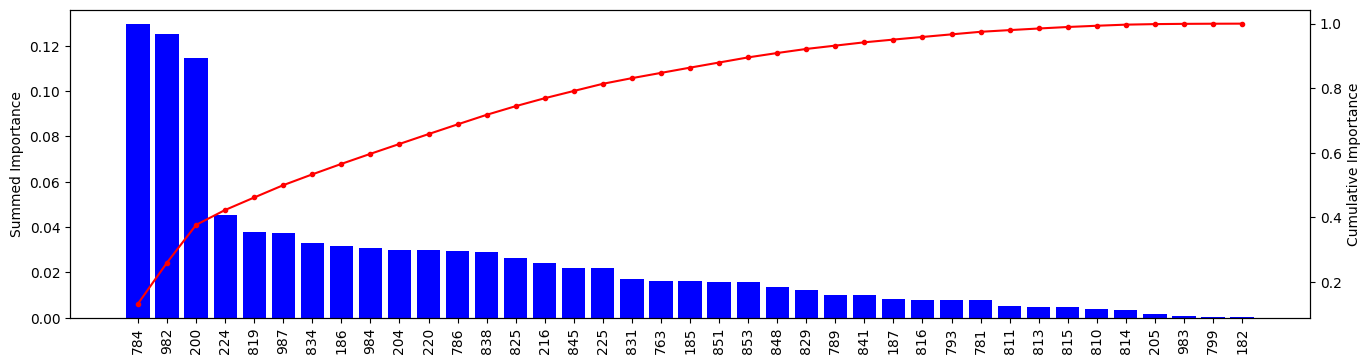

Index(['182_A', '182_K', '185_A', '185_F', '185_I', '185_L', '185_M', '185_N',
       '185_S', '185_T',
       ...
       '987_C', '987_D', '987_E', '987_F', '987_H', '987_P', '987_Q', '987_R',
       '987_S', '987_V'],
      dtype='object', length=365)


In [6]:
msa.select_features(plot=True)
print(msa.selected_features)

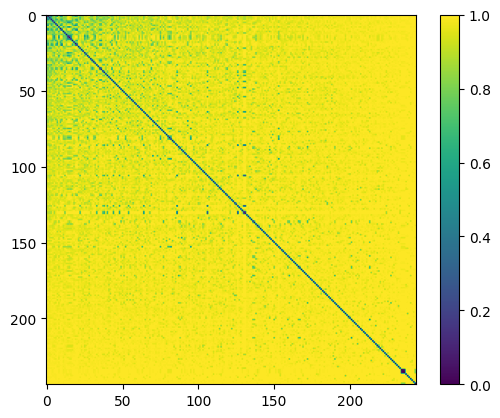

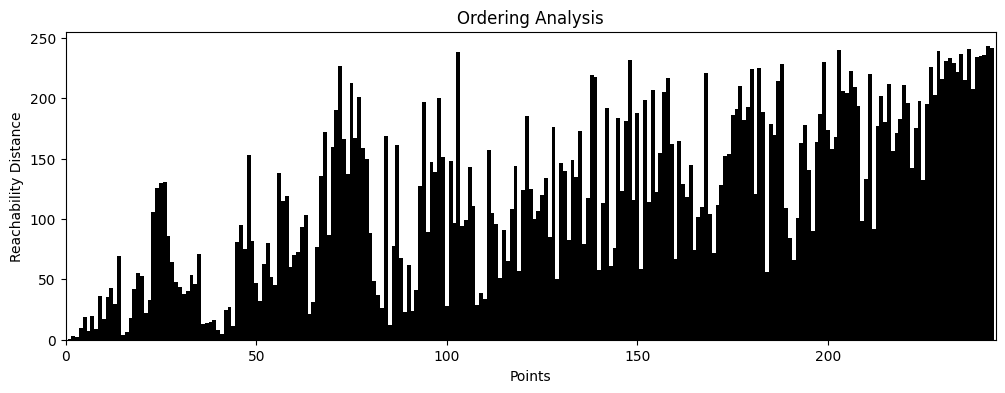

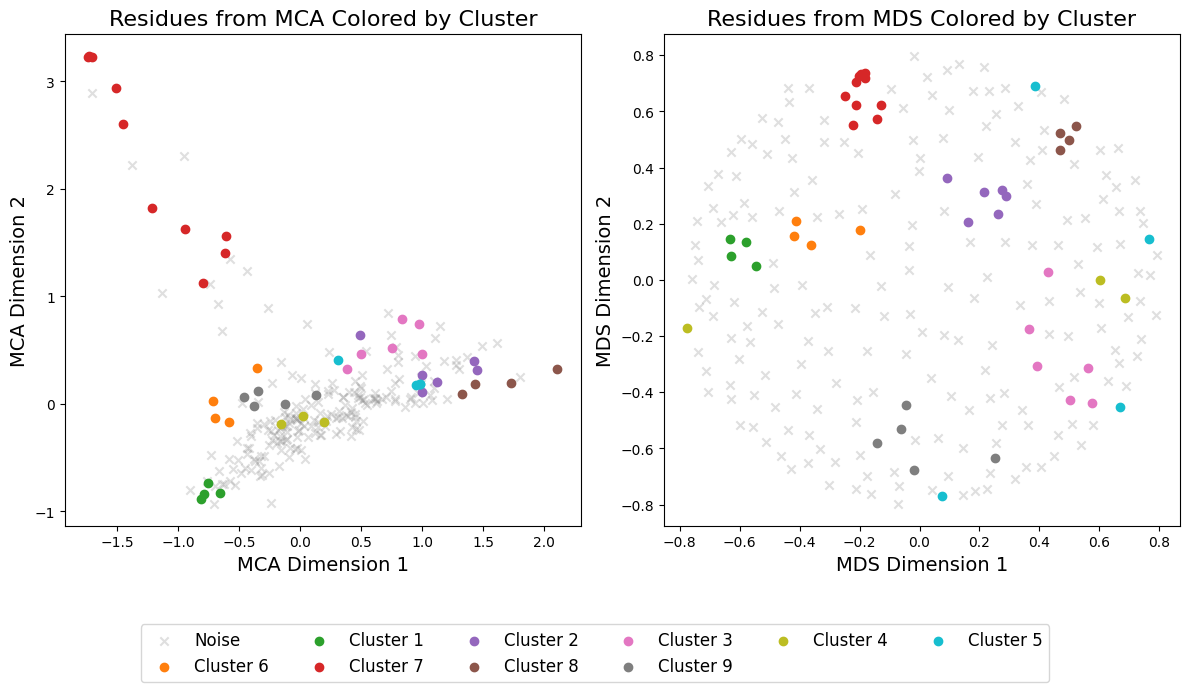

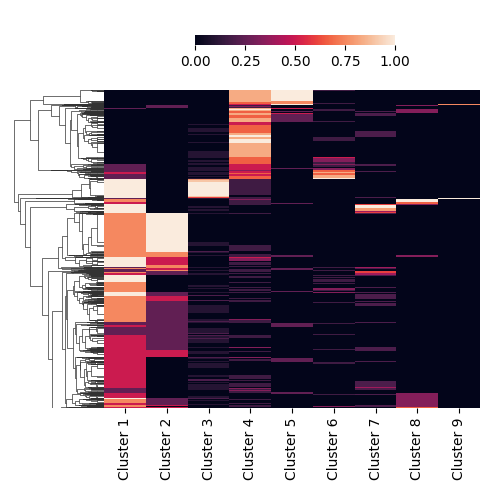

{-1: ['Val825', 'Asp853', 'Arg786', 'Gly204', 'Pro848', 'Lys851', 'Val845', 'Glu829', 'Val216', 'Gly224', 'Ala186', 'Pro851', 'Thr216', 'Gly853', 'Leu216', 'Leu819', 'Val186', 'Thr829', 'Val786', 'Tyr845', 'Ala216', 'Phe784', 'Thr831', 'Glu853', 'Arg829', 'Thr225', 'Tyr784', 'His848', 'Trp834', 'Phe984', 'Ala845', 'Thr834', 'Leu186', 'Gln786', 'Leu984', 'Pro853', 'Thr786', 'Phe825', 'Ala987', 'Leu848', 'Leu825', 'Ser204', 'Asp834', 'Ile825', 'Ile819', 'Ile831', 'Phe225', 'Ala220', 'Val819', 'Val829', 'Arg984', 'Ile216', 'Gln224', 'Ala984', 'Ile186', 'Arg819', 'Phe845', 'Asp987', 'Tyr834', 'Gln186', 'Leu838', 'Ala831', 'Met825', 'Gly984', 'Phe831', 'Ala204', 'Lys220', 'Ala851', 'His784', 'Ser831', 'Arg848', 'Tyr838', 'Ala853', 'Ala838', 'Arg845', 'Thr838', 'Ala848', 'Asp848', 'Val984', 'Asp851', 'Tyr831', 'Leu784', 'Ile786', 'Arg220', 'Arg987', 'Ile838', 'Ser216', 'Thr984', 'Trp829', 'Leu845', 'Ser786', 'Asn216', 'Asp224', 'Thr819', 'His786', 'Thr204', 'Ser225', 'Ser987', 'Arg834', 'Ile

In [7]:
msa.get_clusters(plot=True)
print(msa.clusters)